In [24]:
import plotly.express as px
import plotly.graph_objects as go
#data imports
import pandas as pd
import numpy as np
import os
import pandas_datareader.data as web
from datetime import datetime
from alpha_vantage.timeseries import TimeSeries
import scipy as sc
ts = TimeSeries(key='YOUR_API_KEY',output_format='pandas', indexing_type='date')

In [78]:
def adjust(date, close, adj_close, in_col, rounding=4):
    '''
    If using forex or Crypto - Change the rounding accordingly!
    '''
    try:
        factor = adj_close / close
        return round(in_col * factor, rounding)
    except ZeroDivisionError:
        print('WARNING: DIRTY DATA >> {} Close: {} | Adj Close {} | in_col: {}'.format(date, close, adj_close, in_col))
        return 0

    
def getTickerData(ticker, start,end):
    df, meta_data = ts.get_daily_adjusted(ticker, outputsize='full')    
    df.sort_index(ascending=True, inplace = True)
    
    df = df[start:end]
    
    df['adj close'] = df['5. adjusted close']
    df['adj open'] = np.vectorize(adjust)(df.index.date, df['4. close'], df['5. adjusted close'], df['1. open'])
    df['adj high'] = np.vectorize(adjust)(df.index.date, df['4. close'], df['5. adjusted close'], df['2. high'])
    df['adj low'] = np.vectorize(adjust)(df.index.date, df['4. close'], df['5. adjusted close'], df['3. low'])    
    #calculate daily returns
    df['daily_return'] = df['adj close'].pct_change()
    # calculate cumluative return
    df['cumluative_return'] = np.exp(np.log1p(df['daily_return']).cumsum())
    
    return df[['adj open','adj close','adj high', 'adj low', 'daily_return', 'cumluative_return'  ]]


def getPtf(tickers, start, end):
    
    ptf = pd.DataFrame()
       
    for stock in tickers:
        df = getTickerData(stock, start, end)
        df.sort_index(ascending=True, inplace = True)
        df = pd.concat({stock: df}, names=['stock'])
        ptf =  pd.concat([df, ptf], axis=0)
        
    return ptf


def getPtfColumns(tickers, start, end):
    
    ptf = pd.DataFrame()
       
    for stock in tickers:
        df = getTickerData(stock, start, end)
        df.sort_index(ascending=True, inplace = True)
        df.columns = pd.MultiIndex.from_product([[stock], df.columns])
        ptf =  pd.concat([df, ptf], axis=1)
        
    return ptf

def getSpecificColumns(ptf, column, stocks):
    new_ptf = pd.DataFrame()

    for each in stocks:
        df = ptf.loc[:, each][[column]]
        df.columns = [each]
        new_ptf = pd.concat([df, new_ptf], axis=1)
    return new_ptf

def ptfPerformance(weights, ptf):
    returns = getSpecificColumns(ptf, 'daily_return', stocks)
    mean_returns = returns.mean()
    cov_matrix = returns.cov()
    weights_a = np.array(weights)
    
    ptf_return = np.sum(mean_returns*weights_a)*252
    
    ptf_std = np.sqrt(np.dot(weights_a.T, np.dot(cov_matrix, weights_a ))) * np.sqrt(252)
    
    return ptf_return, ptf_std

def stockPerformanceAnnualised(stock_daily_return):
    
    return np.mean(stock_daily_return)*252, np.std(stock_daily_return)*np.sqrt(252)


def randomWeights(n):
    k = np.random.rand(n)
    return k/sum(k)

def retrurnsAndStd(ptf, stocks, iterations):
    df = pd.DataFrame(columns = ['return', 'std', 'weights'])
    for i in range(iterations):
        weights = randomWeights(len(stocks))
        returns, std = ptfPerformance(weights, ptf)
        df.loc[i] = returns, std, weights
    return df

In [89]:
stocks = ['SPOT','PYPL','BABA', 'MSFT', 'MO']

In [5]:
#ptf = getPtf(stocks, '2020-01-01','2021-01-01')

In [90]:
ptf = getPtfColumns(stocks, '2020-01-01','2021-01-01')

In [91]:
ptf

MO                                            \
           adj open  adj close adj high  adj low daily_return   
date                                                            
2020-01-02  45.2199  44.372980  45.3550  44.1928          NaN   
2020-01-03  44.3009  44.715350  45.0037  44.2919     0.007716   
2020-01-06  44.7154  44.895545  45.1118  44.5352     0.004030   
2020-01-07  44.6523  44.661292  44.9856  44.4360    -0.005218   
2020-01-08  44.8595  45.120789  45.3010  44.6703     0.010288   
...             ...        ...      ...      ...          ...   
2020-12-24  41.1748  41.007687  41.2043  40.4497    -0.006765   
2020-12-28  41.1748  40.771785  41.5630  40.5359    -0.005753   
2020-12-29  40.9389  40.034590  41.0863  40.0248    -0.018081   
2020-12-30  39.9854  40.044419  40.2705  39.6611     0.000246   
2020-12-31  39.9363  40.299980  40.4032  39.4842     0.006382   

                                  MSFT                                  ...  \
           cumluative_return  adj open   adj close  adj high   adj low  ...   
date                                                                    ...   
2020-01-02               NaN  156.7556  158.572113  158.6807  156.3113  ...   
2020-01-03          1.007716  156.3014  156.597613  157.9107  156.0448  ...   
2020-01-06          1.011777  155.0772  157.002385  157.0715  154.5145  ...   
2020-01-07          1.006497  157.2887  155.570873  157.6342  155.3142  ...   
2020-01-08          1.016853  156.9037  158.048871  158.7498  155.9362  ...   
...                      ...       ...         ...       ...       ...  ...   
2020-12-24          0.924159  220.9134  222.240358  223.0984  220.6939  ...   
2020-12-28          0.918843  223.9365  224.445302  225.5129  222.5097  ...   
2020-12-29          0.902229  225.7922  223.637155  226.6602  223.0685  ...   
2020-12-30          0.902451  224.7147  221.172806  225.1138  220.9633  ...   
2020-12-31          0.908210  221.1928  221.911113  222.4898  219.1774  ...   

               PYPL                                             SPOT  \
           adj high  adj low daily_return cumluative_return adj open   
date                                                                   
2020-01-02   111.21  109.275          NaN               NaN   151.00   
2020-01-03   110.42  108.760    -0.017968          0.982032   149.50   
2020-01-06   110.22  107.440     0.012964          0.994763   151.49   
2020-01-07   111.56  109.530    -0.004538          0.990248   156.70   
2020-01-08   112.64  109.820     0.019604          1.009661   156.33   
...             ...      ...          ...               ...      ...   
2020-12-24   242.12  238.090    -0.003341          2.154763   329.81   
2020-12-28   243.50  235.250    -0.012194          2.128488   331.28   
2020-12-29   236.25  229.680    -0.019938          2.086050   320.95   
2020-12-30   233.84  230.020     0.002078          2.090384   323.47   
2020-12-31   234.69  229.690     0.011619          2.114673   323.50   

                                                                      
           adj close adj high adj low daily_return cumluative_return  
date                                                                  
2020-01-02    151.62   152.80  149.61          NaN               NaN  
2020-01-03    152.50   153.59  149.50     0.005804          1.005804  
2020-01-06    156.72   157.00  150.35     0.027672          1.033637  
2020-01-07    156.02   157.85  155.01    -0.004467          1.029020  
2020-01-08    158.78   159.48  155.34     0.017690          1.047223  
...              ...      ...     ...          ...               ...  
2020-12-24    328.39   336.34  327.62    -0.007255          2.165875  
2020-12-28    317.29   331.55  316.00    -0.033801          2.092666  
2020-12-29    318.43   323.90  310.55     0.003593          2.100185  
2020-12-30    319.35   323.47  316.17     0.002889          2.106252  
2020-12-31    314.66   323.50  312.47    -0.014686          2.07532

In [92]:
returns = getSpecificColumns(ptf, 'daily_return', stocks)

In [93]:
cum_returns = getSpecificColumns(ptf, 'cumluative_return', stocks)

<AxesSubplot:xlabel='date'>

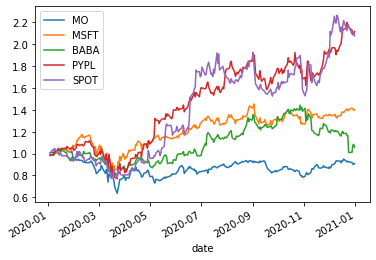

In [94]:
cum_returns.plot()

<AxesSubplot:xlabel='date'>

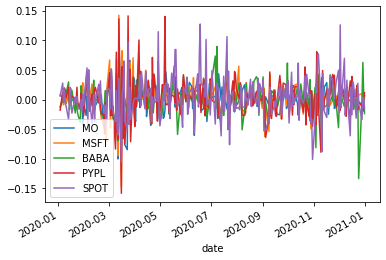

In [95]:
returns.plot()

In [99]:
df = retrurnsAndStd(ptf,stocks, 1000)

In [100]:
opt_weights_loc = (-df['return']/df['std']).idxmin()
opt_weights = df.loc[(-df['return']/df['std']).idxmin()]['weights']
for each in range(len(stocks)):
    print(list(reversed(stocks))[each]+': '+str(opt_weights[each]*100))

MO: 3.2043310677615024
MSFT: 0.27550361813715085
BABA: 2.2238093338898643
PYPL: 49.380687116710426
SPOT: 44.91566886350106


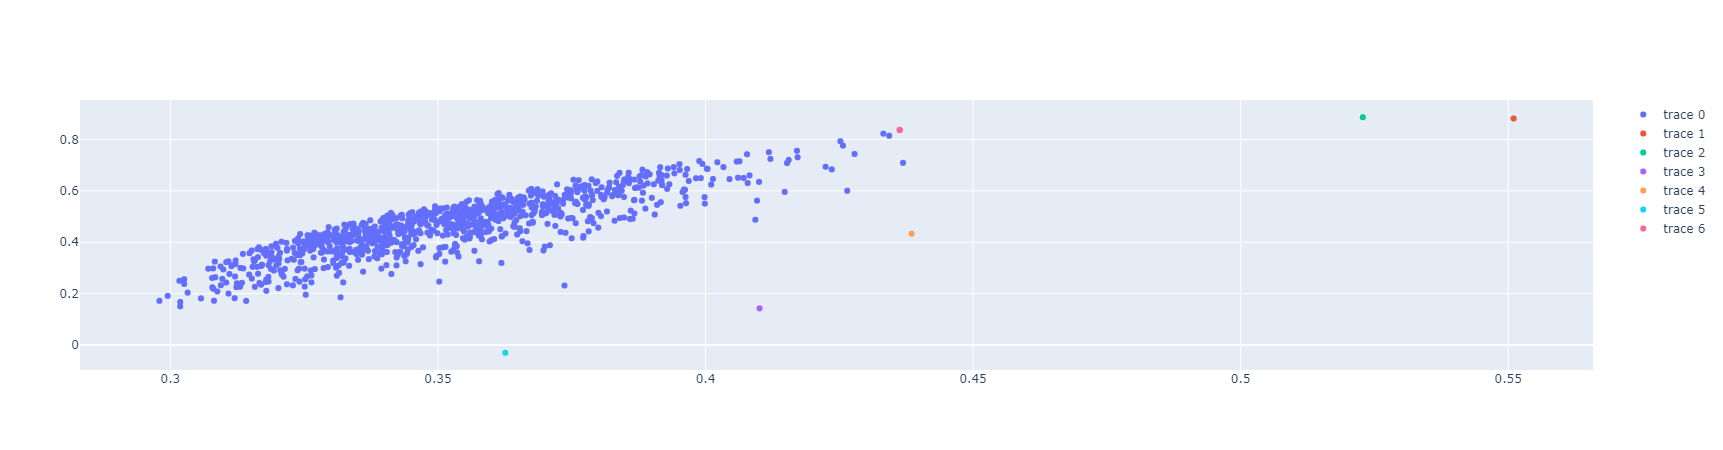

In [101]:
fig = go.Figure([
    go.Scatter(
        x=df['std'],
        y=df['return'],
        mode='markers'
    )
])


for each in stocks:

    fig.add_trace(go.Scatter(
            x=np.array(stockPerformanceAnnualised(ptf[each]['daily_return'])[1]),
            y=np.array(stockPerformanceAnnualised(ptf[each]['daily_return'])[0]),
            mode='markers',
            text = each))
    
fig.add_trace(go.Scatter(
            x=np.array(df.loc[opt_weights_loc]['std']),
            y=np.array(df.loc[opt_weights_loc]['return']),
            mode='markers',
            text = 'Optimal portolio'))

fig.show()